# Fit Model


In [1]:
import pandas as pd
import mlutils
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
# column names
feature_col = "features" # feature vector
value_col = "foldClass" # f# fold class to be predicted

### Read data set with fold type classifications and feature vectors

In [3]:
df = pd.read_json("./features.json")

In [4]:
print("Total number of data:", df.shape[0], "\n")
df.head(2)

Total number of data: 5370 



,Exptl.,FreeRvalue,R-factor,alpha,beta,coil,features,foldClass,length,ngram,pdbChainId,resolution,secondary_structure,sequence
1,XRAY,0.26,0.19,0.469945,0.046448,0.483607,"[0.11604863300000001, 0.1514298506, 0.36337655...",alpha,366,"[SR, RM, MP, PS, SP, PP, PM, MP, PV, VP, PP, P...",16VP.A,2.1,CCSCCCCCCCCHHHHHHHHHHHHTCTTHHHHHHHHHHCCCCCSTTS...,SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSAL...
1000,XRAY,0.23,0.18,0.504630,0.004630,0.490741,"[0.3882268729, 0.2888651389, 0.061335582300000...",alpha,216,"[ME, EA, AD, DV, VE, EQ, QQ, QA, AL, LT, TL, L...",1PBW.B,2.0,CCCCCCCCCCCCCCHHHHCCTTSCSCHHHHHHHHHHHHHHTTCTTT...,MEADVEQQALTLPDLAEQFAPPDIAPPLLIKLVEAIEKKGLECSTL...


## Split dataset into a training and test set

In [5]:
train, test = train_test_split(df, test_size=0.25, random_state=13, stratify=df[value_col])
print("Training set size:", train.shape[0], "\n")
print(train[value_col].value_counts())
print()
print("Test set size:", test.shape[0], "\n")
print(test[value_col].value_counts())

Training set size: 4027 

alpha         2107
alpha+beta    1266
beta           654
Name: foldClass, dtype: int64

Test set size: 1343 

alpha         703
alpha+beta    422
beta          218
Name: foldClass, dtype: int64


## Train a classifier

In [6]:
classifier = svm.SVC(gamma='auto', class_weight='balanced', random_state=13)
#classifier = LogisticRegression(class_weight='balanced')
#classifier = RandomForestClassifier(random_state=13, class_weight='balanced')

classifier.fit(train[feature_col].tolist(), train[value_col].tolist())

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=13, shrinking=True,
  tol=0.001, verbose=False)

## Make prediction for test set

In [7]:
predicted = classifier.predict(test[feature_col].tolist())
expected = test[value_col].tolist()

## Calculate metrics for test set

Classification metrics:

             precision    recall  f1-score   support

      alpha       0.87      0.74      0.80       703
 alpha+beta       0.62      0.71      0.66       422
       beta       0.68      0.80      0.73       218

avg / total       0.76      0.74      0.75      1343



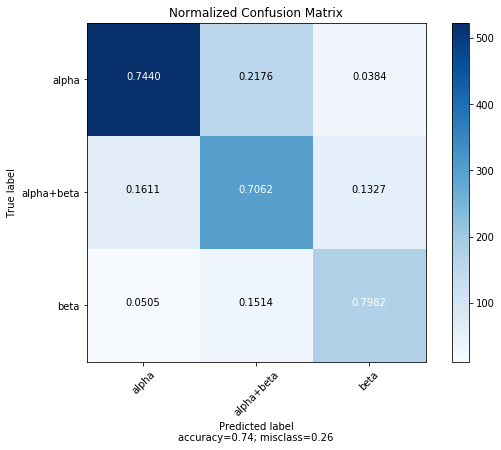

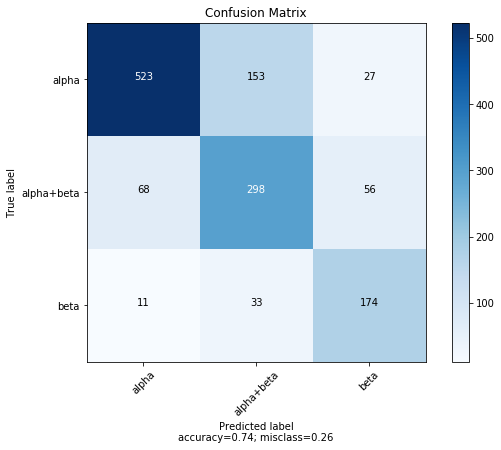

In [8]:
cm = metrics.confusion_matrix(expected, predicted)
print("Classification metrics:\n")
print(metrics.classification_report(expected, predicted))
mlutils.plot_confusion_matrix(cm, classifier.classes_, normalize=True, title='Normalized Confusion Matrix')
mlutils.plot_confusion_matrix(cm, classifier.classes_, normalize=False, title="Confusion Matrix")